# Model Selection



<br>

### Imports

In [1]:
# imports from Python Standard Library
import re, warnings

from itertools import combinations
from collections import Counter, OrderedDict
from statistics import mean

In [2]:
# Third party imports
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier


In [3]:
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

In [4]:
# sklearn imports
from sklearn.metrics import (accuracy_score, recall_score, precision_score, fbeta_score, roc_auc_score, classification_report)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import roc_auc_score
from sklearn.exceptions import NotFittedError
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import clone

# imbalanced-learn imports
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler


In [5]:
# Custom-made utilities
from src.helper_utilities import load_data
from src.modeling_utilities import Baseline, classification_scores, f2_scorer, auc_scorer
from src.plotting_utilities import plot_probabilities_distributions, plot_errors
from src.computing_utilities import optimize_threshold, error_sets_difference

In [6]:
# Settings
#warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

### Random Seed

In [7]:
random_state = 42

# Data Preprocessing

### Note how the features are ordered in the original dataset

In [8]:
# View the attribute names from the info document
path = 'data/german.doc'

with open(path, mode='r') as file:
    text = file.read()
    
pattern = r"Attr?ibute (?P<attr>\d{1,2}):.+?\n\s+(?P<name>.+?)\n"

print('\033[91m{}\033[0m'.format("Column index,"),  "original feature name and", '\033[92m{}\033[0m'.format("my short name"), end="\n\n")

# make a mapping from the "handy" name to the actual column index
column_index = dict()

df = pd.read_csv("data/user_friendly_cats.csv")

for m in re.finditer(pattern, text):
    possible_names = [s for s in df.columns for pattern in (fr"\b{s}\b", fr"\b{s[:-1]}")
                      if re.search(pattern, m.groupdict()['name'], re.IGNORECASE)] or ['tenure']
    my_column_name = Counter(sorted(possible_names)).most_common(1)[0][0]
    print('\033[91m{}\033[0m'.format(int(m.groupdict()['attr'])-1), f"{m.groupdict()['name'].strip()}", '\033[92m({})\033[0m'.format(my_column_name))
    column_index[my_column_name] = int(m.groupdict()['attr'])-1


Column index, original feature name and my short name

0 Status of existing checking account (status)
1 Duration in month (tenure)
2 Credit history (history)
3 Purpose (purpose)
4 Credit amount (amount)
5 Savings account/bonds (savings)
6 Present employment since (employment)
7 Installment rate in percentage of disposable income (rate)
8 Personal status and sex (personal)
9 Other debtors / guarantors (guarantor)
10 Present residence since (residence)
11 Property (property)
12 Age in years (age)
13 Other installment plans (installments)
14 Housing (housing)
15 Number of existing credits at this bank (credits)
16 Job (job)
17 Number of people being liable to provide maintenance for (maintenance)
18 Telephone (telephone)
19 foreign worker (foreign)


### Load the original dataset

We'll opt for DataFrame as input into our model because we will want to determine feature data types dynamically with pandas' functionality.

In [9]:
# load the original dataset as df
X, y = load_data(mode='modeling', format='dataframe', introduce_nans=0.01, random_state=random_state)
X.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
995,A14,12.0,A32,A42,1736.0,A61,A74,3.0,A92,A101,4.0,A121,31.0,A143,A152,1.0,A172,1.0,A191,A201
996,A11,30.0,A32,A41,3857.0,A61,A73,4.0,A91,A101,4.0,A122,40.0,A143,A152,1.0,A174,1.0,A192,A201
997,A14,12.0,A32,A43,804.0,A61,A75,4.0,A93,A101,4.0,A123,38.0,A143,A152,1.0,A173,1.0,A191,A201
998,A11,45.0,A32,A43,1845.0,A61,A73,4.0,A93,A101,4.0,A124,23.0,A143,A153,1.0,A173,1.0,A192,A201
999,A12,45.0,A34,A41,4576.0,A62,A71,3.0,A93,A101,4.0,A123,27.0,A143,A152,1.0,A173,1.0,A191,A201


### Train Test Split

Because we do not want to touch the test set and we do not want any information leakage from the val set, we will split the dataset as follows.

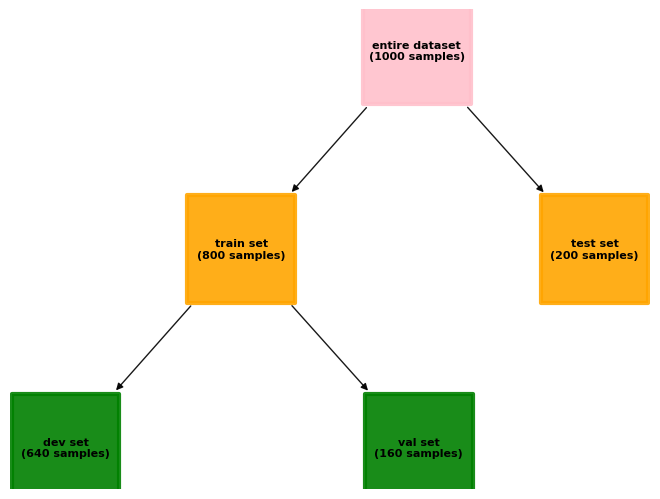

In [10]:
G = nx.DiGraph()  # with arrows

# Add nodes
G.add_node(0, label="entire dataset\n(1000 samples)", color='pink')
G.add_node(1, label="train set\n(800 samples)", color='orange')
G.add_node(2, label="test set\n(200 samples)", color='orange')
G.add_node(3, label="dev set\n(640 samples)", color='green')
G.add_node(4, label="val set\n(160 samples)", color='green')

# Add edges
G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(1, 3)
G.add_edge(1, 4)

pos = graphviz_layout(G, prog="dot")

labels = nx.get_node_attributes(G, "label")
colors = [G.nodes[node]['color'] for node in G.nodes()]

nx.draw(G, pos, with_labels=False, 
                arrows=True,
                node_shape="s",    # so^>v<dph8
                node_size=6000, 
                node_color=colors, 
                font_color='k',
                edge_color="k", 
                linewidths=3, 
                font_weight="bold", 
                alpha=0.9)

nx.draw_networkx_labels(G, pos, labels=labels, 
                                font_color="black", 
                                font_size=8, 
                                font_weight="bold")
plt.axis('off')  # Turn off axis
plt.savefig("assets/graph.png")  # Save as PNG

In [11]:
# the "orange" dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)

# the "green" dataset
X_dev, X_val, y_dev, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

# X_... is a pd.DataFrame
X_test[:3]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
690,A11,15.0,A34,A42,975.0,A61,A73,2.0,A91,A101,3.0,A122,25.0,A143,A152,2.0,A173,1.0,A191,A201
296,A14,12.0,A32,A41,4675.0,A65,A72,NaN,A92,A101,4.0,A123,20.0,A143,A151,1.0,A173,1.0,A191,A201
672,A14,60.0,A32,A40,10366.0,A61,A75,2.0,A93,A101,4.0,A122,42.0,A143,A152,1.0,A174,1.0,A192,A201


# Shortlist promissing models

Quick and dirty models:
- logistic regression (L1) - remember to include the ratio feature
- logistic regressio  (L2) with poly dummy interactions etc
- naive bayes (Gaussian vs Categorical?)
- tree / random forest
- gradient boosting
- support vector machine
- neural network

metric: F2, AUC

In [12]:
# collect metrics 
collector = dict()

input_features = sorted(column_index.keys(), key=lambda k: column_index[k])

cv = 5

In [13]:
# Logistic Regression with L1 penalty

def make_ratio_pipline(imputer_strategy='median', log=False):
    steps = [
        ("imputer", SimpleImputer(strategy=imputer_strategy)),
        ("ratio", FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]], feature_names_out=lambda self, feature_names_in: ["ratio"])),
        ("log", FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out=lambda self, feature_names_in: ["log"])),
        ("scaler", StandardScaler()),
    ]

    if not log:
        del steps[-2]
    return Pipeline(steps)

# pipeline for the continuous numerical features
continuous_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),  # because the numerical features are right skewed
    ("log", FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out=lambda self, feature_names_in: [f"log_{name}" for name in feature_names_in])),   # comment out if necessary
    ("scaler", StandardScaler())
])

# pipeline for the discrete numerical features
discrete_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), StandardScaler())

# pipeline for the categorical features
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    )


# numerical features
continuous_features = [1, 4, 12]
discrete_features = [7, 10, 15, 17]
ratio_features = [1, 12]

steps = [
    ("transformer",
        ColumnTransformer([
            ("ratio", make_ratio_pipline(imputer_strategy='median', log=True), ratio_features),
            ("continuous", continuous_pipeline, continuous_features),
            ("discrete", discrete_pipeline, discrete_features),
            ("categorical", categorical_pipeline, make_column_selector(dtype_include=['category', object]))
                    ], 
                remainder='drop')),
    ("classifier", LogisticRegression(penalty='l1', C=1.0, solver='liblinear', class_weight='balanced', random_state=random_state))
]

lr = pl = Pipeline(steps)

collector[pl[-1].__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


In [14]:
# Logistic Regression with L2 and Dummy/Poly Interaction

def make_ratio_pipline(imputer_strategy='median', log=False):
    steps = [
        ("imputer", SimpleImputer(strategy=imputer_strategy)),
        ("ratio", FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]], feature_names_out=lambda self, feature_names_in: ["ratio"])),
        ("log", FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out=lambda self, feature_names_in: ["log"])),
        ("scaler", StandardScaler()),
    ]

    if not log:
        del steps[-2]
    return Pipeline(steps)

# pipeline for the continuous numerical features
continuous_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),  # because the numerical features are right skewed
    ("log", FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out=lambda self, feature_names_in: [f"log_{name}" for name in feature_names_in])),   # comment out if necessary
    ("scaler", StandardScaler())
])

# pipeline for the discrete numerical features
discrete_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), MinMaxScaler())

# pipeline for the categorical features
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    )


# numerical features
continuous_features = [1, 4, 12]
discrete_features = [7, 10, 15, 17]
ratio_features = [1, 12]

transformer = ColumnTransformer([
            ("ratio", make_ratio_pipline(imputer_strategy='median', log=True), ratio_features),
            ("continuous", continuous_pipeline, continuous_features),
            ("discrete", discrete_pipeline, discrete_features),
            ("categorical", categorical_pipeline, make_column_selector(dtype_include=['category', object]))
                    ], remainder='drop')

pr = pl = Pipeline([("transformer", transformer), 
                    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
                    ("classifier", LogisticRegression(penalty='l2', C=1.0, solver='liblinear', class_weight='balanced', random_state=random_state))])


collector[pl[-1].__class__.__name__ + 'Poly'] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


In [15]:
# Naive Bayes

continuous_features = [1, 4, 12]
discrete_features = [7, 10, 15, 17]
categorical_features = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]
ratio_features = [1, 12]   # optional

# Gaussian NB
continuous_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),  # because the numerical features are right skewed
    ("log", FunctionTransformer(np.log, feature_names_out=lambda self, feature_names_in: [f"log_{name}" for name in feature_names_in])),   # comment out if necessary
    ("scaler", StandardScaler())
])

pl_num = make_pipeline(
    ColumnTransformer([
        ("num", continuous_pipeline, continuous_features),
        ("ratio", make_ratio_pipline(imputer_strategy='median', log=True), ratio_features)
                        ], remainder='drop'), 
    GaussianNB()
    )


# Categorical NB
pl = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

pl_cat = nb = make_pipeline(
    ColumnTransformer([("cat", pl, discrete_features + categorical_features)], remainder='drop'), 
    CategoricalNB()
    )

# Ensemble NB
nb = pl = vc = VotingClassifier(estimators=[("num", pl_num), ("cat", pl_cat)], voting='soft', weights=(0.01, 0.99))


collector[pl.__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


# adjust the balance
print(
cross_val_score(pl_num, X_train, y_train, scoring=f2_scorer, cv=cv).mean(),
cross_val_score(pl_cat, X_train, y_train, scoring=f2_scorer, cv=cv).mean(),
cross_val_score(vc, X_train, y_train, scoring=f2_scorer, cv=cv).mean()
)


0.33922418132087767 0.5031322930461071 0.5031322930461071


In [16]:
# Decision Tree 

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')
    )

steps = [
    #("oversampler", RandomOverSampler(random_state=random_state)),

    ("transformer",
        ColumnTransformer([
            ("num", SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number)),
            ("cat", cat_pipeline, make_column_selector(dtype_include=['category', object]))
                    ],
                remainder='passthrough'),
    ),

    ("classifier", DecisionTreeClassifier(min_samples_leaf=3, class_weight='balanced', random_state=random_state))
]


dt = pl = ImbPipeline(steps)


collector[pl[-1].__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


In [17]:
# Random Forest

rf = pl = clone(dt)
pl.steps[-1] = ("classifier", RandomForestClassifier(n_estimators=100, class_weight='balanced'))


collector[pl[-1].__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


In [18]:
# Gradient Boosting

cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

steps = [
    #("oversampler", RandomOverSampler(random_state=random_state)),

    ("transformer",
        ColumnTransformer([
            ("num", SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number)),
            ("cat", cat_pipeline, make_column_selector(dtype_include=['category', object]))
                    ],
                remainder='passthrough'),
    ),

    ("classifier", LGBMClassifier(objective='binary', class_weight='balanced', random_state=random_state))
]

# Fit, cross-validate
gb = pl = ImbPipeline(steps)


collector[pl[-1].__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


[LightGBM] [Info] Number of positive: 189, number of negative: 443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 632, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [19]:
# SVC

num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')
    )

steps = [
    #("oversampler", RandomOverSampler(random_state=random_state)),

    ("transformer",
        ColumnTransformer([
            ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
            ("cat", cat_pipeline, make_column_selector(dtype_include=['category', object]))
                    ],
                remainder='passthrough'),
    ),

    ("classifier", SVC(probability=True, class_weight='balanced', random_state=random_state))
]


sv = pl = ImbPipeline(steps)


collector[pl[-1].__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


In [20]:
# ANN

def make_ratio_pipline(imputer_strategy='median', log=False):
    steps = [
        ("imputer", SimpleImputer(strategy=imputer_strategy)),
        ("ratio", FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]], feature_names_out=lambda self, feature_names_in: ["ratio"])),
        ("log", FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out=lambda self, feature_names_in: ["log"])),
        ("scaler", StandardScaler()),
    ]

    if not log:
        del steps[-2]
    return Pipeline(steps)

# pipeline for the continuous numerical features
continuous_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),  # because the numerical features are right skewed
    ("log", FunctionTransformer(np.log)),   # comment out if necessary
    ("scaler", StandardScaler())
])

# pipeline for the discrete numerical features
discrete_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), StandardScaler())

# pipeline for the categorical features
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    )


# numerical features
continuous_features = [1, 4, 12]
discrete_features = [7, 10, 15, 17]
ratio_features = [1, 12]

steps = [
    #("oversampler", RandomOverSampler(random_state=random_state)),

    ("transformer",
        ColumnTransformer([
            ("ratio", make_ratio_pipline(imputer_strategy='median', log=True), ratio_features),
            ("continuous", continuous_pipeline, continuous_features),
            ("discrete", discrete_pipeline, discrete_features),
            ("categorical", categorical_pipeline, make_column_selector(dtype_include=['category', object]))
                    ], 
                remainder='passthrough'),
    ),
    
    ("classifier", MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=900, random_state=random_state))
]

nn = pl = ImbPipeline(steps)


collector[pl[-1].__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


In [21]:
pd.DataFrame(collector).T.sort_values('F2', ascending=False).round(2)

,F2,sd(F2),AUC,balanced accuracy,F1
LogisticRegression,0.66,0.07,0.78,0.71,0.60
SVC,0.64,0.07,0.80,0.72,0.60
LGBMClassifier,0.58,0.06,0.78,0.71,0.59
MLPClassifier,0.56,0.07,0.75,0.70,0.57
DecisionTreeClassifier,0.56,0.04,0.66,0.65,0.52
LogisticRegressionPoly,0.55,0.07,0.74,0.67,0.54
VotingClassifier,0.50,0.10,0.78,0.67,0.53
RandomForestClassifier,0.37,0.08,0.79,0.64,0.45


### Analyze feature importance

In [22]:
# Feature importances according to the logistic regression model
lr.fit(X_train, y_train)
sr = pd.Series(lr[-1].coef_.ravel(), index=lr[-2].get_feature_names_out(input_features=input_features)).sort_values(key=abs, ascending=False)
print("top most important features in the logistic model:")
sr.head(25)

top most important features in the logistic model:


categorical__purpose_A41         -1.629412
categorical__savings_A64         -1.620818
categorical__status_A14          -1.461549
categorical__purpose_A48         -1.417272
categorical__status_A13          -1.027162
categorical__history_A34         -0.810996
categorical__foreign_A202        -0.801825
categorical__property_A124        0.797228
categorical__savings_A65         -0.748915
categorical__purpose_A43         -0.689892
categorical__installments_A143   -0.660526
categorical__personal_A93        -0.649866
categorical__purpose_A42         -0.644360
categorical__history_A31          0.553502
categorical__purpose_A49         -0.551297
categorical__employment_A74      -0.525675
categorical__purpose_A410        -0.462907
categorical__guarantor_A103      -0.400038
categorical__personal_A94        -0.334097
categorical__job_A174             0.302881
categorical__savings_A62         -0.300645
categorical__status_A12          -0.296498
categorical__property_A122        0.285436
continuous_

In [23]:
print("least important features in the logistic model:")
sr.tail(10)

least important features in the logistic model:


discrete__residence              -0.060761
discrete__maintenance             0.044418
discrete__credits                 0.026770
categorical__installments_A142   -0.019120
categorical__purpose_A44          0.000000
categorical__personal_A92         0.000000
categorical__job_A172             0.000000
continuous__log_age               0.000000
categorical__employment_A73       0.000000
categorical__purpose_A46          0.000000
dtype: float64

In [24]:
# Feature importances according to the tree model
dt.fit(X_train, y_train)
sr = pd.Series(dt[-1].feature_importances_, index=dt[-2].get_feature_names_out(input_features=input_features)).sort_values(ascending=False)
print("top most important features in the tree model:")
sr.head(10)

top most important features in the tree model:


num__amount               0.158897
cat__status_A14           0.151391
num__tenure               0.093141
cat__history_A34          0.077898
num__age                  0.075050
cat__savings_A61          0.042179
cat__purpose_A42          0.032509
cat__employment_A72       0.032235
cat__installments_A143    0.031978
cat__guarantor_A101       0.031191
dtype: float64

In [25]:
print("least important features in the tree model:")
sr.tail(10)

least important features in the tree model:


cat__guarantor_A102    0.0
cat__personal_A92      0.0
cat__employment_A71    0.0
cat__purpose_A48       0.0
cat__purpose_A45       0.0
cat__purpose_A44       0.0
cat__history_A30       0.0
cat__status_A11        0.0
num__maintenance       0.0
cat__foreign_A202      0.0
dtype: float64

In [26]:
# Feature importances according to the random forest model
rf.fit(X_train, y_train)
sr = pd.Series(rf[-1].feature_importances_, index=rf[-2].get_feature_names_out(input_features=input_features)).sort_values(ascending=False)
print("top most important features in the tree model:")
sr.head(10)

top most important features in the tree model:


num__amount         0.094733
num__tenure         0.077995
num__age            0.074993
cat__status_A14     0.058222
cat__status_A11     0.039398
num__residence      0.033045
num__rate           0.032886
cat__savings_A61    0.024970
cat__history_A34    0.024961
cat__status_A12     0.023021
dtype: float64

In [27]:
print("least important features in the random forest model:")
sr.tail(10)

least important features in the random forest model:


cat__history_A30       0.006711
cat__personal_A91      0.006488
cat__guarantor_A102    0.006104
cat__housing_A153      0.004938
cat__foreign_A202      0.004797
cat__purpose_A45       0.003920
cat__job_A171          0.001792
cat__purpose_A44       0.001692
cat__purpose_A410      0.001603
cat__purpose_A48       0.000835
dtype: float64

[LightGBM] [Info] Number of positive: 237, number of negative: 554
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 791, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

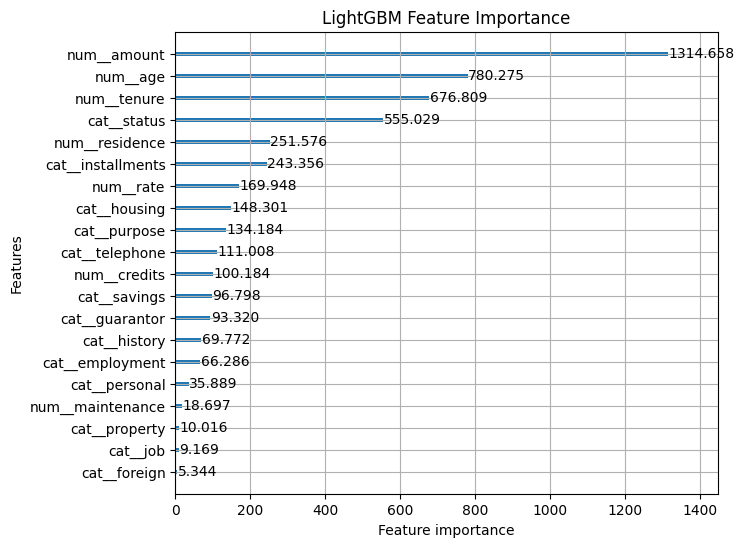

In [28]:
# Feature importances according to the gradient boosting model
gb.fit(X_train, y_train)
params = {f"{gb.steps[-1][0]}__categorical_feature": list(range(len(X_train.select_dtypes(include=np.number).columns), X_train.shape[1])),
          f"{gb.steps[-1][0]}__feature_name": list(gb[0].get_feature_names_out(input_features=input_features))}
gb.fit(X_train, y_train, **params)
lgb.plot_importance(gb.steps[-1][1], importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance");

### Determine the features which may be excluded from our model

According to our statistical tests earlier these features are useless: ['residence', 'job', 'credits', 'telephone', 'maintenance']

In [29]:
# sorted bad to worst
weak_features = ['residence', 'job', 'credits', 'telephone', 'maintenance']
features_to_keep = sorted(set(range(X.shape[1])) - set(column_index[k] for k in weak_features))

#input_features
#TODO

### View how certain the models are about their predictions

The following distributions of predicted probabilities show that the most certain models are the neural network, decision tree, followed by gradient boosting

[LightGBM] [Info] Number of positive: 194, number of negative: 438
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 632, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

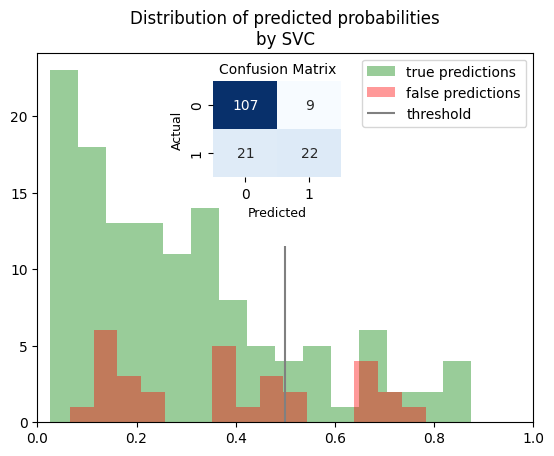

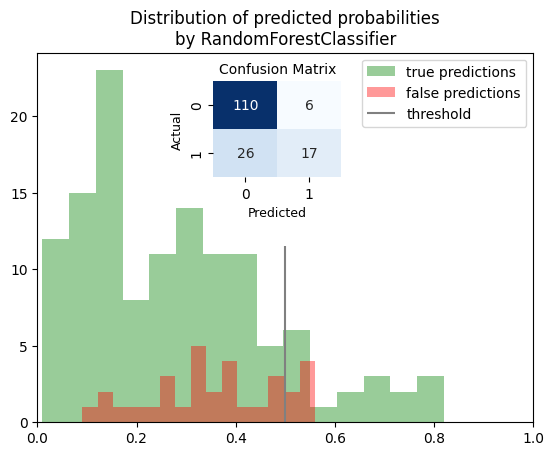

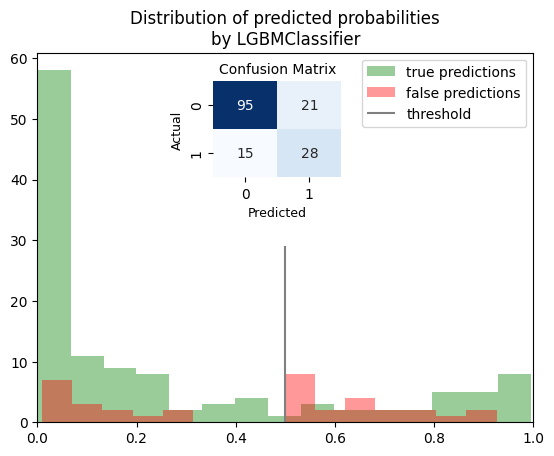

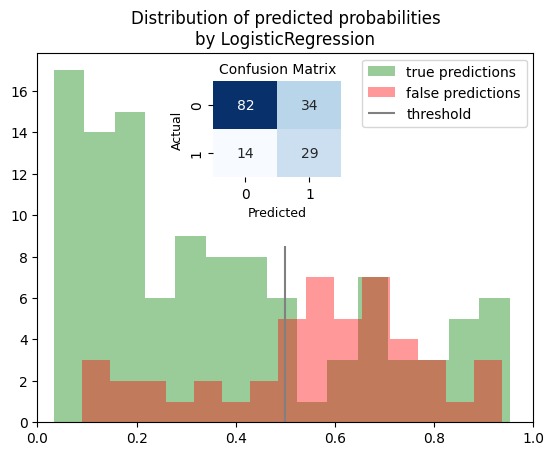

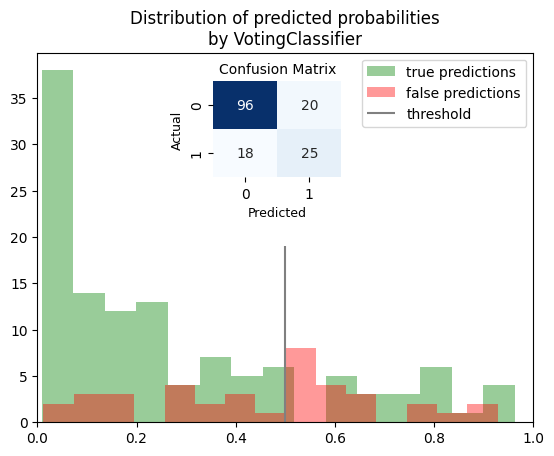

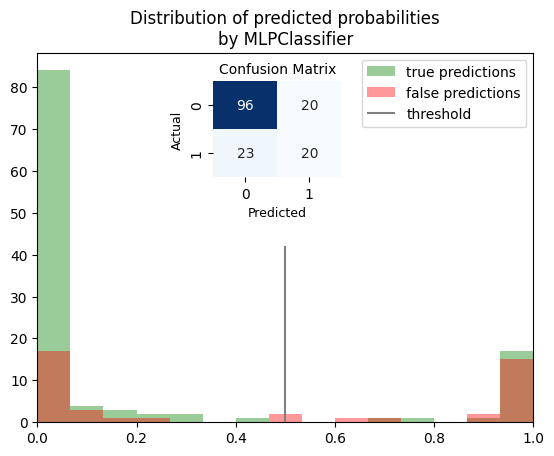

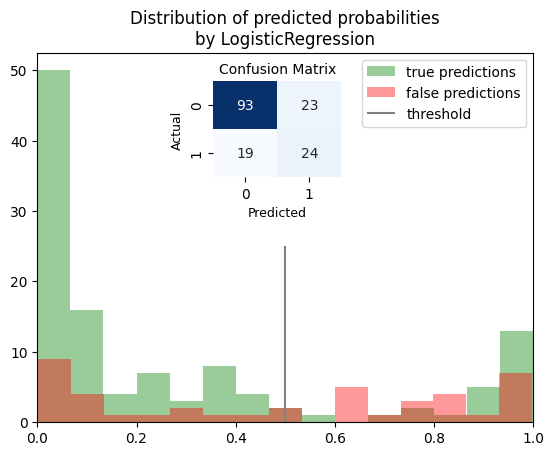

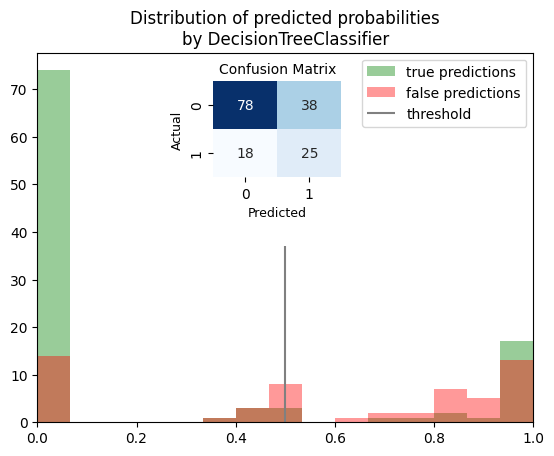

In [33]:
# View the distributions of predictions (ordered by the AUC)
mapping = dict(zip(('RandomForestClassifier', 'LogisticRegression', 'SVC', 'LGBMClassifier', 'VotingClassifier', 'MLPClassifier', 'DecisionTreeClassifier', 'LogisticRegressionPoly'),
        (rf, lr, sv, gb, vc, nn, dt, pr)))

models = [mapping[k] for k in pd.DataFrame(collector).T.sort_values('AUC', ascending=False).index]

for model in models:
    fig = plt.figure()
    model.fit(X_dev, y_dev)
    plot_probabilities_distributions(model, X_val, y_val, n_bins=15, alpha=0.4)



### Have a look at the confusion matreces:

[LightGBM] [Info] Number of positive: 194, number of negative: 438
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 632, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

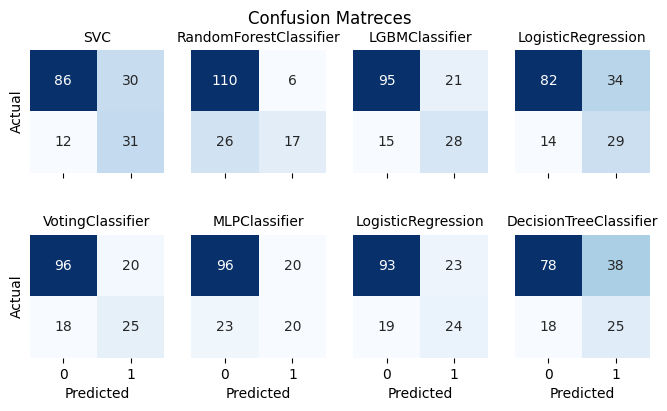

In [37]:
# Make confusion matreces (with cross validation using the train set)

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(8,4))
fig.suptitle("Confusion Matreces")

for i, (md, ax) in enumerate(zip(models, axes.ravel())):
    md.fit(X_dev, y_dev)
    cm = confusion_matrix(y_val, md.predict(X_val))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted') if i in (4,5,6,7) else ax.set_xticks([])
    ax.set_ylabel('Actual') if i in (0,4) else ax.set_yticks([])
    ax.set_title((md[-1] if hasattr(md, '__len__') else md).__class__.__name__, fontsize=10)
#plt.delaxes(axes.ravel()[-1])
plt.subplots_adjust(hspace=0.5);

### Visualize how diverse the classifiers are in making errors

[LightGBM] [Info] Number of positive: 195, number of negative: 437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 632, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

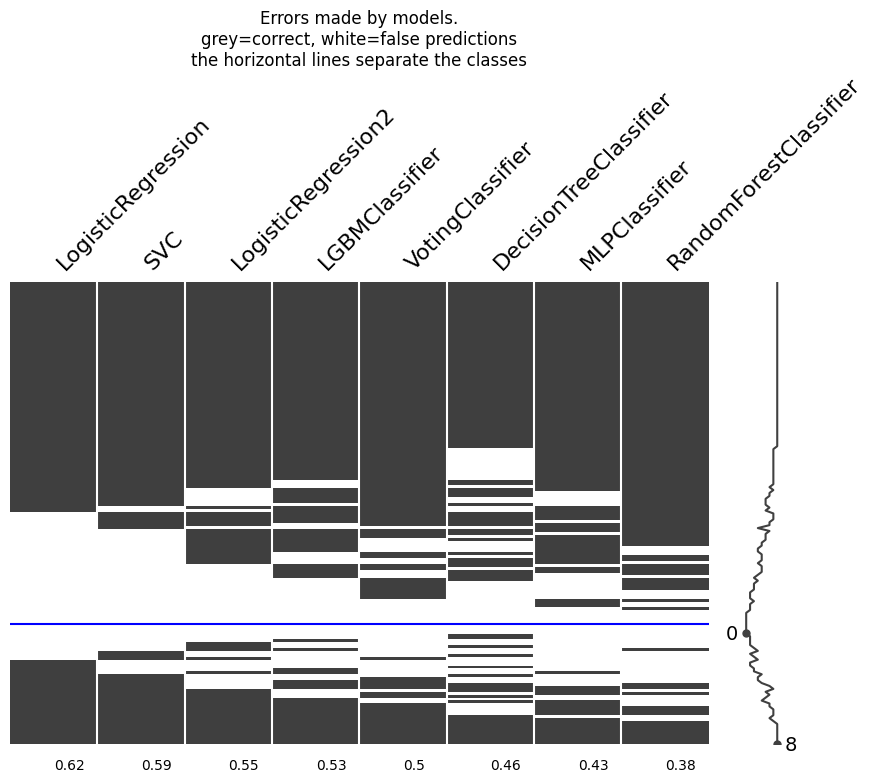

In [39]:
# my custom function to visualize errors
plot_errors(X_train, y_train, estimators=models, scorer=f2_scorer);

### Save the models

joblib.dump(model, 'model_filename.pkl')

loaded_model = joblib.load('model_filename.pkl')

## TODO

- separate the notebooks



- impute
- do not resample because the imbalance is not dramatic
- transform
- classify (use class_weight)


### try a new classifier:
Logistic Rgeresiion with L2, ratios, interactions, poly-expansion (also on the dummies)



- decide which feature(s) to exclude - maybe make a FeatureDropper transformer
- HP for F2 each clf - or for AUC?
- make all possible combinjations of classifyer ensembels to get the best f2, after threshold optimization

In [41]:


params = {'classifier__solver': ['liblinear', 'saga'], 'classifier__C': np.logspace(-2, 0, num=5, base=10), 'classifier__max_iter': [900]}

gs = GridSearchCV(lr, params, cv=5, scoring=f2_scorer).fit(X_train, y_train)

gs.best_estimator_
gs.best_params_
gs.best_score_



0.6775492438959284

In [43]:
gs.best_params_

{'classifier__C': 0.31622776601683794,
 'classifier__max_iter': 900,
 'classifier__solver': 'saga'}


# THE CHECKLIST

## Prepare the data
...

3. Encode, dummify categorical features. Maybe "numerize" categorical features with too many categories.

4. Feature engineering, where appropriate:
    - Discretize continuous features.
    - Decompose features (e.g., categorical, date/time, etc.)  SEX
    - Add promising transformations of features (e.g., log(x), sqrt(x), x^2, etc.).
    - Aggregate features into promising new features.

5. Feature scaling: standardize or normalize features.

## Short-list promising models  
Notes: 
- If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time (be aware that this penalizes complex models such as large neural nets or Random Forests).  
- Once again, try to automate these steps as much as possible.    

1. Train many quick and dirty models from different categories (e.g., linear, naive, Bayes, SVM, Random Forests, neural net, etc.) using standard parameters.  
2. Measure and compare their performance.  
    - For each model, use N-fold cross-validation and compute the mean and standard deviation of their performance. 
3. **Analyze the most significant variables for each algorithm.**
4. Analyze the types of errors the models make.  
    - What data would a human have used to avoid these errors?  
5. Have a quick round of feature selection and engineering.  
6. Have one or two more quick iterations of steps 1-5  
7. Short-list the top 3-5 most promising models, preferring models that **make different types of errors.**  






### Checklist:
https://github.com/leztien/Projects-Portfolio/blob/main/CHECKLITST.md




# Error Analysis
(read)
ChatGPT:

Performing an error analysis is an essential step in understanding a model's performance and the types of errors it makes. Here are steps to perform an error analysis:
1. Collect Predictions and True Labels

    Start with your model's predictions on a validation or test set.
    Collect the true labels corresponding to these predictions.

2. Confusion Matrix

    Construct a confusion matrix. This is particularly useful for classification tasks.
    For each class, the confusion matrix shows how many samples were correctly classified and how many were misclassified into other classes.
    This helps in understanding which classes are often confused with each other.

3. Calculate Metrics

    Calculate standard evaluation metrics like accuracy, precision, recall, and F1-score.
    These metrics provide an overall view of the model's performance but can be limited in understanding specific errors.

4. Analyze Misclassifications

    Look at individual samples that were misclassified.
    Examine the features, context, or patterns of these samples to identify commonalities.
    Pay attention to edge cases or samples with ambiguous labels.

5. Class-wise Analysis

    Perform a class-wise analysis:
        For each class, look at precision, recall, and F1-score.
        Identify which classes have low precision (false positive rate) or low recall (false negative rate).
        Determine if there's a class imbalance affecting the model's performance.

6. Visualizations

    Use visualizations to aid in understanding errors:
        Plotting actual vs. predicted values.
        ROC curves or precision-recall curves for binary classification.
        Distribution of scores or probabilities for correct and incorrect predictions.
        Feature importance or contribution to misclassifications.

7. Error Patterns

    Look for recurring error patterns:
        Are there specific types of inputs (e.g., images, sentences) that are consistently misclassified?
        Are there particular feature values or combinations that lead to errors?

8. Human Review

    In some cases, involve human reviewers to:
        Check misclassified samples to verify if the model's predictions are reasonable.
        Annotate the reason for misclassifications.
        Provide insights that might not be apparent from automated analysis.

9. Addressing Errors

    Based on the analysis, consider strategies to address specific errors:
        Collect more data for underrepresented classes.
        Engineer new features that might help the model.
        Adjust the model's hyperparameters.
        Use techniques like ensembling or different models for specific classes.




# UPSAMPLING VS CLASS_WEIGHT
(read and delete)

Whether to upsample the rare class or use the class_weight parameter in scikit-learn depends on various factors, including the size of your dataset, computational resources, and the specific characteristics of your problem. Here's a breakdown:
Upsampling the Rare Class:

Upsampling involves creating more samples of the minority class to balance the class distribution.
Pros:
    It directly addresses class imbalance by providing the model with more examples of the minority class.
    Can lead to better generalization and performance, especially when the minority class is important and you have enough computational resources.
Cons:
    May lead to overfitting if not done carefully.
    Increases the dataset size, which can impact training time and memory usage, especially for large datasets.

Using class_weight Parameter:

The class_weight parameter adjusts the algorithm's optimization process to pay more attention to the minority class.
Pros:
    Easier to implement, as it's just a parameter setting in the model.
    Doesn't increase the dataset size.
    Can be effective for smaller datasets where upsampling might not be feasible.
Cons:
    Might not work as well for extremely imbalanced datasets.
    Can be less effective if the minority class is extremely rare.
    May not provide as much improvement as upsampling, especially for very imbalanced data.

When to Use Each:

Use Upsampling:
    When you have enough computational resources to handle the increased dataset size.
    When the minority class is crucial and you want the model to have more exposure to it.
    For smaller to medium-sized datasets where upsampling is feasible.

Use class_weight:
    When you have limited computational resources or a very large dataset where upsampling might be too expensive.
    When the imbalance is not extreme and you want a simpler approach.
    For quick experimentation and prototyping.